In [1]:
import numpy as np

import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['axes.unicode_minus'] = False

# 从文件读取数据

In [2]:
def loadDataSet(filename):
    X = []
    Y = []
    
    with open(filename, 'rb') as f:
        for idx, line in enumerate(f):
            line = line.decode('utf-8').strip()
            if not line:
                continue
            eles = line.split()
            eles = list(map(float, eles))
            
            if idx == 0:
                numFea = len(eles)
            X.append(eles[:-1])
            Y.append([eles[-1]])
    
    return np.array(X), np.array(Y)

# 构建逻辑回归模型

## （1）定义 sigmoid 函数
   $$ g(z) = \frac{1}{1+e^{-z}} $$

In [3]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

## （2）定义 cost 函数（带正则化）
$$ J(\theta) = \frac{1}{m} [ \sum_{i=1}^{m} (-y^{(i)}\log(h_{\theta}(x^{(i)})) - (1-y^{(i)})\log{(1-h_{\theta}(x^{(i)}))})] + \lambda \frac{1}{2m} \sum_{j=1}^n \theta_j^2 $$

其中，$ h_\theta(X) = g(\theta^T X) = \frac{1}{1+e^{-\theta^T X}}$

In [4]:
def costReg(theta, X, Y, Lamda):
    # 初始化矩阵对象
    theta = np.matrix(theta)
    X = np.matrix(X)
    Y = np.matrix(Y)
    
    # 构造代价函数
    first = np.multiply(-Y, np.log(sigmoid(X*theta.T)))
    second = np.multiply((1-Y), np.log(1-sigmoid(X*theta.T)))
    reg = Lamda / (2.0*len(X)) * np.sum(np.power(theta[:,1:theta.shape[1]],2))
    return np.sum(first - second) / len(X) + reg

In [5]:
# 这里为了后面的手动梯度下降计算方便，直接让 theta 成了一个 竖向量，也就不需要转置
def costReg2(theta, X, Y, Lamda):
    # 初始化矩阵对象
    theta = np.matrix(theta)
    X = np.matrix(X)
    Y = np.matrix(Y)
    
    # 构造代价函数
    first = np.multiply(-Y, np.log(sigmoid(X*theta)))
    second = np.multiply((1-Y), np.log(1-sigmoid(X*theta)))
    reg = Lamda / (2.0*len(X)) * np.sum(np.square(theta[1:]))
    return np.sum(first - second) / len(X) + reg

## （3）定义梯度下降函数
$$ \theta := \theta - \alpha  \frac{1}{m} (h_\theta(x^{(i)})-y^{(i)}) x_j^{(i)} - \alpha \frac{\lambda}{m}\theta $$

In [6]:
# 方法一：仅仅定义了梯度的计算方法，并未实现下降
# 后面采用给定的库直接实现
def gradientReg(theta, X, Y, learningRate):  
    theta = np.matrix(theta) # 转化为矩阵
    X = np.matrix(X)
    Y = np.matrix(Y)
    
    parameters = int(theta.ravel().shape[1]) # 计算 theta 的个数
    grad = np.zeros(parameters)
    
    error = sigmoid(X * theta.T) - Y
    
    for i in range(parameters):
        term = np.multiply(error, X[:1]) # 两矩阵相乘
        
        if (i == 0):
            grad[i] = np.sum(term) / len(X) # 一般来说第一个参数不需要正则化
        else:
            grad[i] = (np.sum(term) / len(X)) + ((float(learningRate) / len(X)) * theta[:,i])
            
    return grad

In [7]:
# 方法二：直接手动定义梯度下降函数

def gradientReg2(X, Y, options):
    '''
    options.alpha 学习率
    options.theLambda 正则参数λ
    options.maxLoop 最大迭代轮次
    options.epsilon 判断收敛的阈值
    options.method
        - 'sgd' 随机梯度下降
        - 'bgd' 批量梯度下降
    '''
    
    m, n = X.shape
    
    # 获取相关的参数选项
    # Python 字典dict.get(key, default=None)函数返回指定键的值，如果值不在字典中返回默认值
    alpha = options.get('alpha', 0.01)
    epsilon = options.get('epsilon', 0.00001)
    maxloop = options.get('maxloop', 1000)
    theLambda = float(options.get('theLambda', 0)) # 后面有 theLambda/m 的计算，如果这里不转成float，后面这个就全是0
    method = options.get('method', 'bgd')
    
    # 初始化模型参数，n 个特征对应 n 个参数
    theta = np.zeros((n,1))
    
    # 初始化当前误差（初始时不带正则）
    cost = costReg2(theta, X, Y, 0)
    
    # 将计算的中间值用数组保存下来，第一项是初始值
    costs = [cost]
    thetas = [theta]
    
    
    # 定义随机梯度下降
    def _sgd(theta):
        count = 0
        converged = False
        while count < maxloop:
            if converged :
                break
            # 随机梯度下降，每一个样本都更新
            for i in range(m):
                h =sigmoid(np.dot(X[i].reshape((1,n)), theta))
                
                theta = theta - alpha*((1.0/m)*X[i].reshape((n,1))*(h-Y[i]) + (theLambda/m)*np.r_[[[0]], theta[1:]])
                thetas.append(theta)
                cost = costReg2(theta, X, Y, theLambda)
                costs.append(cost)
                if abs(costs[-1] - costs[-2]) < epsilon:
                    converged = True
                    break
            count += 1
        return thetas, costs, count
    
    
    # 定义批量梯度下降
    def _bgd(theta):
        count = 0
        converged = False
        while count < maxloop:
            if converged :
                break
            
            h = sigmoid(np.dot(X, theta))
            theta = theta - alpha*((1.0/m)*np.dot(X.T, (h-Y)) + (theLambda/m)*np.r_[[[0]],theta[1:]])
            
            thetas.append(theta)
            cost = costReg2(theta, X, Y, theLambda)
            costs.append(cost)
            if abs(costs[-1] - costs[-2]) < epsilon:
                converged = True
                break
            count += 1
        return thetas, costs, count
    
    methods = {'sgd': _sgd, 'bgd': _bgd}
    return methods[method](theta)   

# 执行测试

## 加载数据

In [8]:
originX, testY = loadDataSet('./TestData/linear.txt')
m, n = originX.shape
testX = np.concatenate((np.ones((m,1)), originX), axis=1) # 手动加入 x0 数据项，全为 1
testX.shape, testY.shape

((100, 3), (100, 1))

-----

## 方法一：利用库函数实现梯度下降

In [9]:
test_theta = np.ones(3)
learningRate = 1
#testX * test_theta.T -testY
gradientReg(test_theta, testX, testY, learningRate)
costReg(test_theta, testX, testY, learningRate)

5.762727132694215

在之前的梯度下降函数中，并没有真正执行梯度下降。我们还需要基于梯度下降计算结果，加入梯度项来实现一个渐变步骤。这里，可以调用 octave 的内建函数 fminunc() 来获得最优的 theta 和最小的 cost。在 python 中，使用 SciPy 的优化 API 来完成。

In [10]:
import scipy.optimize as opt
import time 

start = time.time()
result2 = opt.fmin_tnc(func=costReg, x0=test_theta, fprime=gradientReg, args=(testX, testY, learningRate))
end = time.time()
btime = end - start

result2,btime

((array([-0.08279641, -0.08477411, -0.08477411]), 90, 1), 0.020943403244018555)

### 结果展示

#### 计算结果精度预测

In [11]:
def predict(theta, X):
    probability = sigmoid(X*theta.T)
    return [1 if x >= 0.5 else 0 for x in probability]
theta_min = np.matrix(result2[0])
predicttions = predict(theta_min, testX)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predicttions, testY)]

accuracy = (sum(map(int, correct)) / len(correct))
accuracy

0.57

#### 结果的图形化显示

Text(0, 0.5, '$x_2$')

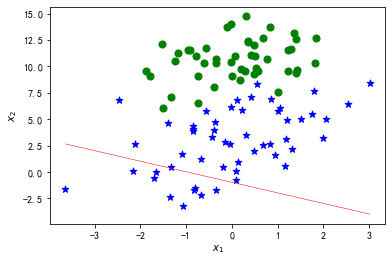

In [12]:
%matplotlib inline
# 绘制决策边界
for i in range(m):
    x = testX[i]
    if testY[i] == 1:
        plt.scatter(x[1], x[2], marker='*', color='blue', s=50)
    else:
        plt.scatter(x[1], x[2], marker='o', color='green', s=50)

hSpots = np.linspace(testX[:,1].min(), testX[:,1].max(), 100)
#theta0, theta1, theta2 = theta_min[-1]
theta0 = theta_min[0,0]
theta1 = theta_min[0,1]
theta2 = theta_min[0,2]
vSpots = -(theta0+theta1*hSpots)/theta2
plt.plot(hSpots, vSpots, color='red', linewidth=.5)

plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

-----

## 方法二：手动实现的 bgd 批量梯度下降

In [13]:
# 设置相关参数
options = {
    'alpha':0.05,
    'epsilon':0.00000001,
    'maxloop':100000,
    'method':'bgd' 
}

start = time.time()
# 训练模型
thetas, costs, iterationCount = gradientReg2(testX, testY, options)
end = time.time()
btime = end - start
thetas[-1], costs[-1], iterationCount, btime

(array([[13.94848025],
        [ 1.19878763],
        [-1.89549859]]),
 0.09333430872838287,
 68010,
 8.75736665725708)

### 结果展示

#### 计算结果精度预测

In [14]:
def predict(theta, X):
    probability = X*theta
    return [1 if sigmoid(x) >= 0.5 else 0 for x in probability]

bgd_X = np.matrix(testX)
bgd_theta = np.matrix(thetas[-1])

predicttions = predict(bgd_theta, bgd_X)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predicttions, testY)]

accuracy = (sum(map(int, correct)) / len(correct))
accuracy

0.95

#### 结果的图形化显示

Text(0, 0.5, '$x_2$')

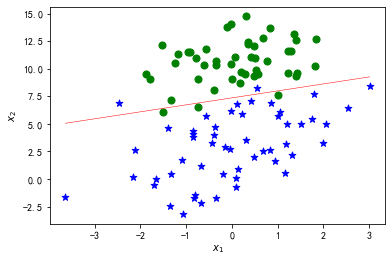

In [15]:
%matplotlib inline
# 绘制决策边界
for i in range(m):
    x = testX[i]
    if testY[i] == 1:
        plt.scatter(x[1], x[2], marker='*', color='blue', s=50)
    else:
        plt.scatter(x[1], x[2], marker='o', color='green', s=50)

hSpots = np.linspace(testX[:,1].min(), testX[:,1].max(), 100)
theta0, theta1, theta2 = thetas[-1]

vSpots = -(theta0+theta1*hSpots)/theta2
plt.plot(hSpots, vSpots, color='red', linewidth=.5)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

------

## 方法三：手动实现的 sgd 随机梯度下降

In [16]:
# 设置相关参数
options = {
    'alpha':0.5,
    'epsilon':0.00000001,
    'maxloop':100000,
    'method':'sgd' 
}

start = time.time()
# 训练模型
thetas, costs, iterationCount = gradientReg2(testX, testY, options)
end = time.time()
btime = end - start
thetas[-1], costs[-1], iterationCount, btime

(array([[ 4.05188699],
        [ 0.47059103],
        [-0.59907261]]),
 0.18906151167614432,
 107,
 1.3982594013214111)

### 结果展示

#### 计算结果精度预测

In [17]:
def predict(theta, X):
    probability = X*theta
    return [1 if sigmoid(x) >= 0.5 else 0 for x in probability]

sgd_X = np.matrix(testX)
sgd_theta = np.matrix(thetas[-1])

predicttions = predict(sgd_theta, sgd_X)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predicttions, testY)]

accuracy = (sum(map(int, correct)) / len(correct))
accuracy

0.98

#### 结果的图形化显示

Text(0, 0.5, '$x_2$')

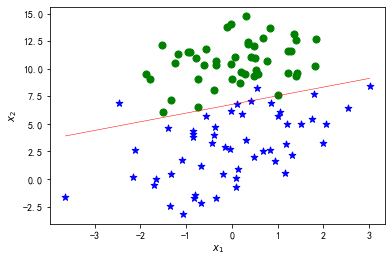

In [18]:
%matplotlib inline
# 绘制决策边界
for i in range(m):
    x = testX[i]
    if testY[i] == 1:
        plt.scatter(x[1], x[2], marker='*', color='blue', s=50)
    else:
        plt.scatter(x[1], x[2], marker='o', color='green', s=50)

hSpots = np.linspace(testX[:,1].min(), testX[:,1].max(), 100)
theta0, theta1, theta2 = thetas[-1]

vSpots = -(theta0+theta1*hSpots)/theta2
plt.plot(hSpots, vSpots, color='red', linewidth=.5)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

# 非线性的逻辑回归

上面的例子中，我们选取的决策边界为 $\theta_0 + \theta_1x_1  + \theta_2x_2$，这是一个线性的边界。在实际问题中，我们可能会遇到更加复杂的例子，如下所示。这时候线性的决策边界就不再满足我们。

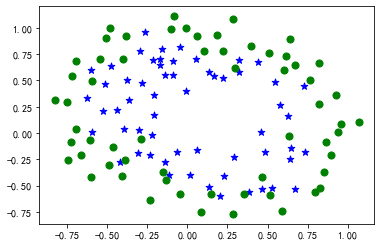

In [19]:
# 加载数据
originX, testY = loadDataSet('./TestData/non_linear.txt')
m, n = originX.shape
testX = np.concatenate((np.ones((m,1)), originX), axis=1)

for i in range(m):
    x = testX[i]
    if testY[i] == 1:
        plt.scatter(x[1], x[2], marker='*', color='blue', s=50)
    else:
        plt.scatter(x[1], x[2], marker='o', color='green', s=50)

这时候，我们就需要利用二阶多项式来构造一个非线性的决策边界。可以利用专门的库 PolynomialFeatures，它可以生成多项式特征，并且多项式包含的是相互影响的特征集。


比如：一个输入样本是 2 维的。形式如 $[a,b]$ ,则二阶多项式的特征集如下 $[1,a,b,a^2,ab,b^2]$

In [20]:
from sklearn.preprocessing import PolynomialFeatures
# 生成阶数为 6 的多项式
poly = PolynomialFeatures(6)
XX = poly.fit_transform(testX[:,1:3])
m, n = XX.shape
m, n

(118, 28)

## 利用 bgd 批量梯度下降开始训练

这个时候，正则化参数将很大的影响模型的拟合程度

### 情景一：$\lambda = 0$

In [21]:
# 训练数据
options = {
    'alpha': 1.0,
    'epsilon': 0.000001,
    'theLambda': 0, # 0
    'maxloop': 10000,
    'method': 'bgd'
}
thetas, errors, iterationCount = gradientReg2(XX, testY, options)
thetas[-1], costs[-1], iterationCount

(array([[ 4.1451001 ],
        [ 2.17554404],
        [ 5.17286461],
        [-5.75908922],
        [-7.48334458],
        [-7.37935231],
        [ 2.3377385 ],
        [-0.4197815 ],
        [ 2.88519296],
        [-2.91104502],
        [-4.63355014],
        [ 3.74363156],
        [-3.95020422],
        [-2.74548867],
        [-5.97721971],
        [-1.71636956],
        [-0.47936793],
        [ 5.24790526],
        [-3.99529724],
        [-3.98839219],
        [ 2.88514401],
        [-5.78603393],
        [ 1.39770805],
        [-0.9758034 ],
        [ 2.96859666],
        [-4.30736326],
        [-3.82567885],
        [ 0.74118165]]),
 0.18906151167614432,
 8861)

图形化结果展示：

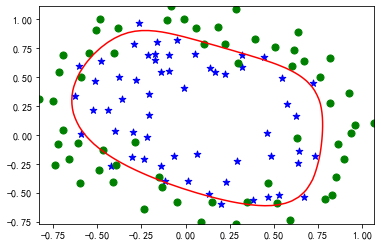

In [22]:
for i in range(m):
    x = testX[i]
    if testY[i] == 1:
        plt.scatter(x[1], x[2], marker='*', color='blue', s=50)
    else:
        plt.scatter(x[1], x[2], marker='o', color='green', s=50)
        
# 绘制决策边界
x1Min,x1Max,x2Min,x2Max = testX[:, 1].min(), testX[:, 1].max(), testX[:, 2].min(), testX[:, 2].max()
xx1, xx2 = np.meshgrid(np.linspace(x1Min, x1Max), np.linspace(x2Min, x2Max))
h = sigmoid(poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()]).dot(thetas[-1]))
h = h.reshape(xx1.shape)
plt.contour(xx1, xx2, h, [0.5], colors='red')

### 情景二：$\lambda = 50$

In [23]:
# 训练数据
options = {
    'alpha': 1.0,
    'epsilon': 0.000001,
    'theLambda': 40, # 0
    'maxloop': 10000,
    'method': 'bgd'
}
thetas, errors, iterationCount = gradientReg2(XX, testY, options)
thetas[-1], costs[-1], iterationCount

(array([[ 0.08766055],
        [-0.03153364],
        [ 0.02457832],
        [-0.13093174],
        [-0.03123081],
        [-0.08755343],
        [-0.03821097],
        [-0.01768284],
        [-0.02051091],
        [-0.04734994],
        [-0.10234463],
        [-0.00502976],
        [-0.03364094],
        [-0.00810249],
        [-0.09401026],
        [-0.04613502],
        [-0.01102099],
        [-0.0080212 ],
        [-0.01470926],
        [-0.01189884],
        [-0.07011423],
        [-0.07976201],
        [-0.00208582],
        [-0.01675221],
        [-0.00067801],
        [-0.01881468],
        [-0.00353575],
        [-0.09270333]]),
 0.18906151167614432,
 17)

图形化结果展示：

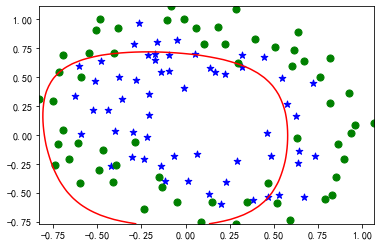

In [24]:
for i in range(m):
    x = testX[i]
    if testY[i] == 1:
        plt.scatter(x[1], x[2], marker='*', color='blue', s=50)
    else:
        plt.scatter(x[1], x[2], marker='o', color='green', s=50)
        
# 绘制决策边界
x1Min,x1Max,x2Min,x2Max = testX[:, 1].min(), testX[:, 1].max(), testX[:, 2].min(), testX[:, 2].max()
xx1, xx2 = np.meshgrid(np.linspace(x1Min, x1Max), np.linspace(x2Min, x2Max))
h = sigmoid(poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()]).dot(thetas[-1]))
h = h.reshape(xx1.shape)
plt.contour(xx1, xx2, h, [0.5], colors='red')

很明显，此时因为 $\lambda$ 设置的过大，图形欠拟合了。

---------

# 与 fate 对比，训练大规模数据

## 加载数据

In [25]:
originX, testY = loadDataSet('./TestData/breast.txt')
m, n = originX.shape
testX = np.concatenate((np.ones((m,1)), originX), axis=1) # 手动加入 x0 数据项，全为 1
testX.shape, testY.shape

((569, 31), (569, 1))

## 利用 sgd 随机梯度下降进行训练

In [26]:
# 设置相关参数
options = {
    'alpha':0.5,
    'epsilon':0.00000001,
    'maxloop':100000,
    'method':'sgd' 
}

start = time.time()
# 训练模型
thetas, costs, iterationCount = gradientReg2(testX, testY, options)
end = time.time()
btime = end - start
thetas[-1], costs[-1], iterationCount, btime

(array([[ 0.13448245],
        [-0.21366699],
        [-0.1514791 ],
        [-0.2140559 ],
        [-0.20489979],
        [-0.08546839],
        [-0.12728507],
        [-0.16845979],
        [-0.2128561 ],
        [-0.07098796],
        [ 0.05453867],
        [-0.16010414],
        [ 0.00633324],
        [-0.1494428 ],
        [-0.15147617],
        [ 0.02346822],
        [-0.01397062],
        [ 0.00286408],
        [-0.06424629],
        [ 0.02400796],
        [ 0.04842544],
        [-0.23604167],
        [-0.1733816 ],
        [-0.23271572],
        [-0.21865653],
        [-0.13764313],
        [-0.14782963],
        [-0.16589003],
        [-0.22442218],
        [-0.13495812],
        [-0.07231662]]),
 0.1904770571056976,
 4,
 0.6427888870239258)

## 计算结果精度预测

### 本实现的训练结果

In [27]:
def predict(theta, X):
    probability = X*theta
    return [1 if sigmoid(x) >= 0.5 else 0 for x in probability]

sgd_X = np.matrix(testX)
sgd_theta = np.matrix(thetas[-1])

predicttions = predict(sgd_theta, sgd_X)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predicttions, testY)]

accuracy = (sum(map(int, correct)) / len(correct))
accuracy

0.9630931458699473

### Fate 的训练结果

In [28]:
def loadCompareDataSet(filename):
   
    Y_com = []
    with open(filename, 'rb') as f:
        for idx, line in enumerate(f):
            line = line.decode('utf-8').strip()
            if not line:
                continue
                
            eles = line.split()
            if idx == 0:
                numFeature = len(eles)
            
            eles = list(map(float, eles)) # 将数据转换成 float 型
            
            Y_com.append(eles[1:2])    # 应该取第二列的数据
            
        return np.array(Y_com)

Y_com = loadCompareDataSet('./TestData/Predict_campare_breast.txt')
# print(Y_com)

correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(Y_com, testY)]

accuracy = (sum(map(int, correct)) / len(correct))
accuracy

0.8945518453427065